# Airbnb Descriptive

<p>Now that we have the predictive model complete, we now look to address the qualities that most affect the experience of Airbnb guests. 
Namely, these include quality features, bedrooms, bathrooms and seasonal features that enchance/detract from one's stay.</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
prices = pd.read_csv('../../data/Ames_Housing_Price_Data.csv',index_col = 0)


In [2]:
#Engineering new features relevant to Airbnb experience
prices['YrSinceUpdate'] = 2010-prices['YearRemodAdd']
prices.drop('YearRemodAdd',axis = 1,inplace = True)
prices['Total_FullBaths'] = prices['BsmtFullBath'] + prices['FullBath']
prices['Total_HalfBaths'] = prices['BsmtHalfBath'] + prices['HalfBath']
prices.drop(['BsmtFullBath','FullBath','BsmtHalfBath','HalfBath'],axis = 1, inplace = True)

In [3]:
airbnb_cols = ['PID','SalePrice','GrLivArea','BldgType','HouseStyle','OverallQual','OverallCond',
              'YearBuilt','YrSinceUpdate','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtFinType1',
              'BsmtFinType2','HeatingQC','CentralAir','Total_FullBaths','Total_HalfBaths','FireplaceQu',
              'BedroomAbvGr','KitchenQual','GarageQual','GarageCond',
               'PoolQC','Fence','MiscFeature','Functional',"Neighborhood"]
prices = prices[airbnb_cols]
prices

,PID,SalePrice,GrLivArea,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YrSinceUpdate,ExterQual,...,FireplaceQu,BedroomAbvGr,KitchenQual,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,Functional,Neighborhood
1,909176150,126000,856,1Fam,1Story,6,6,1939,60,TA,...,Gd,2,TA,TA,TA,NaN,NaN,NaN,Typ,SWISU
2,905476230,139500,1049,TwnhsE,1Story,5,5,1984,26,Gd,...,NaN,2,Gd,TA,TA,NaN,NaN,NaN,Typ,Edwards
3,911128020,124900,1001,1Fam,1Story,5,9,1930,3,Gd,...,NaN,2,Gd,TA,Po,NaN,NaN,NaN,Typ,IDOTRR
4,535377150,114000,1039,1Fam,2Story,4,8,1900,7,Gd,...,NaN,2,TA,TA,TA,NaN,NaN,NaN,Typ,OldTown
5,534177230,227000,1665,1Fam,2Story,8,6,2001,9,Gd,...,NaN,3,Gd,TA,TA,NaN,NaN,NaN,Typ,NWAmes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,903205040,121000,952,1Fam,1.5Unf,6,6,1916,60,TA,...,Gd,2,Fa,Fa,Po,NaN,NaN,NaN,Typ,BrkSide
760,905402060,139600,1733,1Fam,1Story,3,5,1955,55,TA,...,Gd,4,TA,TA,TA,NaN,NaN,NaN,Min2,Edwards
761,909275030,145000,2002,Duplex,2Story,5,6,1949,60,TA,...,NaN,4,TA,TA,TA,NaN,NaN,NaN,Typ,Crawfor
762,907192040,217500,1842,1Fam,2Story,7,5,2000,10,Gd,...,TA,3,Gd,TA,TA,NaN,NaN,NaN,Typ,CollgCr


### Ensure brand quality by filtering out lower quality houses

In [4]:
prices = prices.loc[(prices.BsmtFinType1!= 'LwQ') & (prices.BsmtFinType1 !='Unf')]
prices = prices.loc[(prices.BsmtFinType2!= 'LwQ') & (prices.BsmtFinType2 !='Unf')]
prices = prices.loc[(prices.Functional == 'Typ')&(prices.OverallQual >=5)&(prices.OverallCond >=5)]
prices.drop('Functional',axis = 1, inplace = True)

# Converting quality/condition categoricals to numerical

In [5]:
def ordinal_scale(Series):
    '''Returns a pandas Series where quality scores are converted to integers
    
    Args:
    
    Series: a pandas Series of categorical quality scores'''
    return prices[Series].replace({'Po':None,'Fa':1,'TA':2,'Gd':3,'Ex':4})

prices['KitchenQual'] = ordinal_scale('KitchenQual')
prices['ExterQual'] = ordinal_scale('ExterQual')
prices['ExterCond'] = ordinal_scale('ExterCond')
prices['HeatingQC'] = ordinal_scale('HeatingQC')

In [6]:
prices['BsmtCond'].value_counts()

TA    143
Gd     14
Fa      1
Ex      1
Name: BsmtCond, dtype: int64

In [7]:
def switch_ordinals(Series):
    '''
    Returns a pandas series replacing null values with DNE (Does Not Exist) so they can be imputed.
    
    Args:
    

    Series: str, column name in the pandas dataframe.
    '''
    prices[Series].fillna('DNE',inplace = True)
    return prices[Series]
    
impute_cols = ['BsmtQual','BsmtCond','FireplaceQu',
               'GarageQual','GarageCond','PoolQC']

for i in impute_cols:
    prices[i] = switch_ordinals(i)

for i in impute_cols:
    prices[i].replace({'Po':None,'DNE':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace = True)
    
prices.update(prices[['Fence','BsmtFinType1','BsmtFinType2','MiscFeature']].fillna('None'))



In [8]:
prices.columns

Index(['PID', 'SalePrice', 'GrLivArea', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YrSinceUpdate', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2',
       'HeatingQC', 'CentralAir', 'Total_FullBaths', 'Total_HalfBaths',
       'FireplaceQu', 'BedroomAbvGr', 'KitchenQual', 'GarageQual',
       'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'Neighborhood'],
      dtype='object')

In [9]:
summer_cols = ['PoolQC','CentralAir']
winter_cols = ['FireplaceQu','HeatingQC']

In [10]:
nulls = prices.isnull().sum()
nulls[nulls>1]

FireplaceQu    4
dtype: int64

In [11]:
prices['CentralAir'].replace({'N':0,'Y':1},inplace = True)


prices['Total_FullBaths'] = prices['Total_FullBaths'].fillna(prices['Total_FullBaths'].mean())
prices['Total_HalfBaths'] = prices['Total_HalfBaths'].fillna(prices['Total_HalfBaths'].mean())


In [12]:
nulls = prices.isnull().sum(axis = 0)
nulls[nulls>1]

FireplaceQu    4
dtype: int64

In [13]:
prices.dropna(axis = 0, how = 'any',inplace = True)

# Merge housing data with Geopy data

In [14]:
#merge here

In [15]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 2 to 742
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              177 non-null    int64  
 1   SalePrice        177 non-null    int64  
 2   GrLivArea        177 non-null    int64  
 3   BldgType         177 non-null    object 
 4   HouseStyle       177 non-null    object 
 5   OverallQual      177 non-null    int64  
 6   OverallCond      177 non-null    int64  
 7   YearBuilt        177 non-null    int64  
 8   YrSinceUpdate    177 non-null    int64  
 9   ExterQual        177 non-null    int64  
 10  ExterCond        177 non-null    int64  
 11  BsmtQual         177 non-null    int64  
 12  BsmtCond         177 non-null    int64  
 13  BsmtFinType1     177 non-null    object 
 14  BsmtFinType2     177 non-null    object 
 15  HeatingQC        177 non-null    int64  
 16  CentralAir       177 non-null    int64  
 17  Total_FullBaths 

In [16]:
prices['Neighborhood'].value_counts()

NAmes      57
Edwards    16
Sawyer     15
NWAmes     14
SawyerW    11
Mitchel     9
CollgCr     7
NoRidge     6
Timber      5
Veenker     4
Somerst     4
OldTown     4
IDOTRR      3
ClearCr     3
NridgHt     3
Crawfor     3
Gilbert     2
NPkVill     2
BrkSide     2
GrnHill     2
StoneBr     2
Greens      1
SWISU       1
MeadowV     1
Name: Neighborhood, dtype: int64

In [17]:
prices.sample(10)

,PID,SalePrice,GrLivArea,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YrSinceUpdate,ExterQual,...,Total_HalfBaths,FireplaceQu,BedroomAbvGr,KitchenQual,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,Neighborhood
219,535325090,127000,925,1Fam,1Story,5,8,1956,7,2,...,0.0,1.0,3,3,3,3,1,None,None,NAmes
350,531451110,143000,923,TwnhsE,1Story,6,5,1980,30,2,...,0.0,3.0,2,2,3,3,1,None,None,SawyerW
949,910203020,120500,778,1Fam,1Story,5,6,1940,55,2,...,0.0,4.0,2,2,5,5,1,None,None,IDOTRR
28,534430080,142125,1078,1Fam,1Story,5,6,1950,14,2,...,0.0,1.0,2,3,3,3,1,None,None,NAmes
405,535300120,176000,1382,1Fam,SLvl,6,5,1962,48,2,...,0.0,3.0,3,2,3,3,1,GdWo,None,NAmes
243,528110110,417500,2464,1Fam,1Story,8,5,2007,3,3,...,1.0,5.0,4,4,3,3,1,None,None,NridgHt
67,531450120,171500,1730,1Fam,2Story,6,6,1992,18,3,...,1.0,1.0,3,3,3,3,1,None,None,SawyerW
171,533350020,373000,2497,1Fam,1Story,8,5,1981,29,3,...,0.0,4.0,2,3,3,3,1,None,None,Veenker
520,916460070,202000,1403,1Fam,1Story,6,5,2000,10,3,...,0.0,1.0,2,3,3,3,1,None,None,Timber
576,910200080,126000,919,1Fam,1Story,6,8,1926,12,2,...,0.0,1.0,2,2,3,3,1,MnPrv,None,IDOTRR


In [18]:
ideal_homes = prices.drop(['PID','Neighborhood'],axis = 1)

In [19]:
airbnb_winter = ideal_homes.drop(summer_cols,axis = 1)
airbnb_summer = ideal_homes.drop(winter_cols,axis = 1)

In [20]:
airbnb_summer.columns

Index(['SalePrice', 'GrLivArea', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YrSinceUpdate', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir',
       'Total_FullBaths', 'Total_HalfBaths', 'BedroomAbvGr', 'KitchenQual',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

In [21]:
airbnb_summer['PoolQC'].value_counts()

1    177
Name: PoolQC, dtype: int64

## Reducing to numeric features

In [22]:
airbnb_summer.sample(5)

,SalePrice,GrLivArea,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YrSinceUpdate,ExterQual,ExterCond,...,CentralAir,Total_FullBaths,Total_HalfBaths,BedroomAbvGr,KitchenQual,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
41,122000,1351,1Fam,1.5Fin,5,6,1925,60,2,3,...,1,2.0,0.0,3,2,3,3,1,None,None
309,315000,2063,1Fam,1Story,8,5,1994,15,3,2,...,1,3.0,0.0,3,3,3,3,1,None,None
429,148000,918,1Fam,SLvl,7,6,1975,35,2,2,...,1,1.0,1.0,3,2,3,3,1,None,None
253,235000,1252,1Fam,1Story,6,7,1960,35,2,2,...,1,2.0,0.0,1,2,3,3,1,None,None
110,330000,1502,TwnhsE,1Story,7,5,1998,12,3,2,...,1,2.0,1.0,1,3,3,3,1,None,None


In [23]:
cats = ideal_homes.select_dtypes(object).columns
cats

Index(['BldgType', 'HouseStyle', 'BsmtFinType1', 'BsmtFinType2', 'Fence',
       'MiscFeature'],
      dtype='object')

In [24]:
dummy = pd.get_dummies(ideal_homes, columns = cats)

In [25]:
dummy

,SalePrice,GrLivArea,OverallQual,OverallCond,YearBuilt,YrSinceUpdate,ExterQual,ExterCond,BsmtQual,BsmtCond,...,BsmtFinType2_None,BsmtFinType2_Rec,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Shed
2,139500,1049,5,5,1984,26,3,2,4,3,...,0,0,0,0,0,0,1,0,1,0
6,198500,1922,7,5,2003,7,3,2,1,1,...,1,0,0,0,0,0,1,0,1,0
20,131250,1091,6,5,1993,14,2,3,4,3,...,0,0,0,0,0,0,1,0,0,1
22,115000,789,5,5,1948,60,2,2,3,3,...,0,0,0,0,0,0,1,0,1,0
29,200000,2090,7,6,1973,37,2,2,4,3,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,228000,2097,7,5,1993,17,3,2,4,3,...,0,0,0,0,0,0,1,0,1,0
706,119000,1367,5,8,1900,60,2,2,3,4,...,0,0,0,0,1,0,0,0,1,0
717,137900,892,5,7,1966,2,2,2,3,3,...,0,1,0,0,0,0,1,0,1,0
719,163000,1336,5,5,1969,41,2,2,4,3,...,0,1,0,0,0,0,1,0,0,1


<AxesSubplot:>

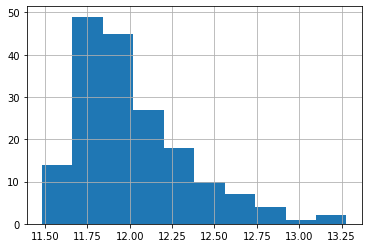

In [26]:
Y = np.log(dummy['SalePrice'])
X = dummy.drop('SalePrice',axis = 1)
Y.hist()

In [27]:
X_columns = dummy.drop('SalePrice',axis = 1).columns
X_columns

Index(['GrLivArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YrSinceUpdate',
       'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
       'CentralAir', 'Total_FullBaths', 'Total_HalfBaths', 'FireplaceQu',
       'BedroomAbvGr', 'KitchenQual', 'GarageQual', 'GarageCond', 'PoolQC',
       'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs',
       'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1Story',
       'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl',
       'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ',
       'BsmtFinType1_None', 'BsmtFinType1_Rec', 'BsmtFinType2_ALQ',
       'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_None',
       'BsmtFinType2_Rec', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv',
       'Fence_MnWw', 'Fence_None', 'MiscFeature_Gar2', 'MiscFeature_None',
       'MiscFeature_Shed'],
      dtype='object')

In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X = sc.fit_transform(X)

In [29]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

reg.fit(X,Y)

LinearRegression()

In [30]:
print(reg.score(X,Y))


from sklearn.metrics import mean_squared_error
Ypred = reg.predict(X)
RMSE = mean_squared_error(Y,Ypred,squared = False)
print(RMSE)

0.9234016093289164
0.0929662903793461


In [31]:
for col, coef in zip(X_columns, reg.coef_):
    print(f'{col}: {coef}')

GrLivArea: 0.1908381762090238
OverallQual: 0.08195252780093812
OverallCond: 0.03351986178558243
YearBuilt: 0.04024347612781523
YrSinceUpdate: 0.002411910991227815
ExterQual: 0.008605979646532258
ExterCond: -0.020374785509148084
BsmtQual: 0.06505638360138623
BsmtCond: 0.026106027397568534
HeatingQC: 0.010885775212820133
CentralAir: -0.0029531025428260944
Total_FullBaths: 0.031872673215671825
Total_HalfBaths: 0.0038317553479957685
FireplaceQu: 0.0402004134222699
BedroomAbvGr: -0.018404774366058016
KitchenQual: 0.009729782308373378
GarageQual: 0.009837728840872327
GarageCond: 0.015621154427757104
PoolQC: -1.0408340855860843e-17
BldgType_1Fam: 0.006369322558651693
BldgType_2fmCon: 0.014404132353657922
BldgType_Duplex: -0.013523180839614722
BldgType_Twnhs: -0.023835298881024865
BldgType_TwnhsE: 0.008008816163953925
HouseStyle_1.5Fin: -0.018882282133014502
HouseStyle_1Story: 0.028216883512290365
HouseStyle_2Story: -0.03031402518868428
HouseStyle_SFoyer: -0.006298163282254443
HouseStyle_SLvl:

Text(0.5, 1.0, 'Standardized feature betas in log(SalePrice) linear model')

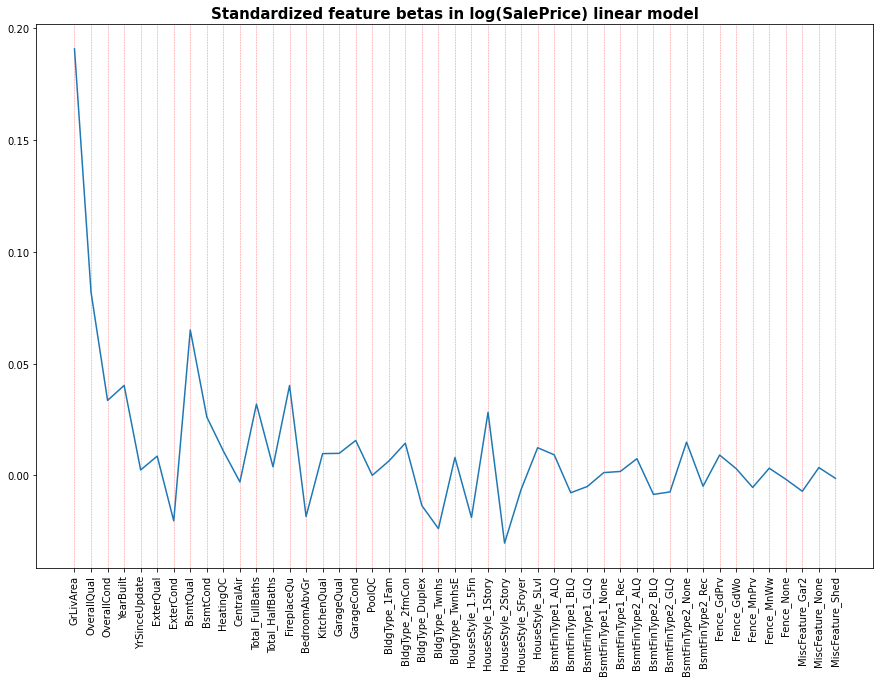

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,10))
plt.plot(list(range(len(X_columns))),reg.coef_)
plt.xticks(list(range(len(X_columns))),labels = X_columns, rotation = 90)
plt.grid(color='r', linestyle='--', linewidth=0.5, axis = 'x',alpha = 0.5)
plt.title('Standardized feature betas in log(SalePrice) linear model', fontsize = 15, fontweight = 'bold')